**Краткая информация о задаче:**

Дан набор нормализованных данных о состоянии устройства на производстве, по которым необходимо определить находится ли устройство в состоянии *0* или *1*

Датасет - Kaggle Tabular Playground Series - May 2022

# 1. Обзор датасета

In [1]:
#Импортируем библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from lightgbm import LGBMClassifier
import warnings, string, random
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff

In [2]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-may-2022/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/tabular-playground-series-may-2022/test.csv', index_col='id')
submission = pd.read_csv('/kaggle/input/tabular-playground-series-may-2022/sample_submission.csv', index_col='id')

In [3]:
print(f"Параметры обучающей выборки: {train.shape[0]} строк и {train.shape[1]} столбцов")
print(f"Параметры тестовой выборки: {test.shape[0]} строк и {test.shape[1]} столбцов")
df = train.describe()
display(df)
train.head()

Параметры обучающей выборки: 900000 строк и 32 столбцов
Параметры тестовой выборки: 700000 строк и 31 столбцов


f_00           f_01           f_02           f_03  \
count  900000.000000  900000.000000  900000.000000  900000.000000   
mean       -0.000286       0.001165       0.001174      -0.001368   
std         0.998888       0.999193       1.000514       1.000175   
min        -4.599856      -4.682199      -4.642676      -4.658816   
25%        -0.675490      -0.675162      -0.674369      -0.676114   
50%         0.001144       0.002014       0.002218      -0.002227   
75%         0.674337       0.675021       0.677505       0.672544   
max         4.749301       4.815699       4.961982       4.454920   

                f_04           f_05           f_06           f_07  \
count  900000.000000  900000.000000  900000.000000  900000.000000   
mean       -0.000571       0.000284      -0.000709       2.031460   
std         1.000167       0.999875       0.999942       1.656172   
min        -4.748501      -4.750214      -4.842919       0.000000   
25%        -0.675909      -0.673437      -0.674876       1.000000   
50%        -0.001662      -0.000438      -0.001492       2.000000   
75%         0.673789       0.675028       0.674749       3.000000   
max         4.948983       4.971881       4.822668      15.000000   

                f_08           f_09  ...           f_21           f_22  \
count  900000.000000  900000.000000  ...  900000.000000  900000.000000   
mean        2.057998       2.362431  ...      -0.156307      -0.009273   
std         1.590955       1.637706  ...       2.484706       2.450797   
min         0.000000       0.000000  ...     -13.310146     -11.853530   
25%         1.000000       1.000000  ...      -1.820063      -1.645585   
50%         2.000000       2.000000  ...      -0.152668       0.030850   
75%         3.000000       3.000000  ...       1.507071       1.661676   
max        16.000000      14.000000  ...      14.455426      11.344080   

                f_23           f_24           f_25           f_26  \
count  900000.000000  900000.000000  900000.000000  900000.000000   
mean       -0.369459      -0.342738       0.176549       0.357591   
std         2.453405       2.386941       2.416959       2.476020   
min       -12.301097     -11.416189     -11.918306     -14.300577   
25%        -2.019739      -1.955956      -1.440424      -1.261598   
50%        -0.390966      -0.340746       0.160912       0.404212   
75%         1.255408       1.266673       1.795928       2.028219   
max        12.247100      12.389844      12.529179      12.913041   

                f_28           f_29           f_30         target  
count  900000.000000  900000.000000  900000.000000  900000.000000  
mean       -0.380876       0.345661       1.002654       0.486488  
std       238.773054       0.475584       0.818989       0.499818  
min     -1229.753052       0.000000       0.000000       0.000000  
25%      -159.427418       0.000000       0.000000       0.000000  
50%        -0.519808       0.000000       1.000000       0.000000  
75%       158.987357       1.000000       2.000000       1.000000  
max      1229.562577       1.000000       2.000000       1.000000  

[8 rows x 31 columns]

f_00      f_01      f_02      f_03      f_04      f_05      f_06  \
id                                                                         
0  -1.373246  0.238887 -0.243376  0.567405 -0.647715  0.839326  0.113133   
1   1.697021 -1.710322 -2.230332 -0.545661  1.113173 -1.552175  0.447825   
2   1.681726  0.616746 -1.027689  0.810492 -0.609086  0.113965 -0.708660   
3  -0.118172 -0.587835 -0.804638  2.086822  0.371005 -0.128831 -0.282575   
4   1.148481 -0.176567 -0.664871 -1.101343  0.467875  0.500117  0.407515   

    f_07  f_08  f_09  ...      f_22      f_23      f_24      f_25      f_26  \
id                    ...                                                     
0      1     5     1  ... -2.540739  0.766952 -2.730628 -0.208177  1.363402   
1      1     3     4  ...  2.278315 -0.633658 -1.217077 -3.782194 -0.058316   
2      1     0     2  ... -1.385775 -0.520558 -0.009121  2.788536 -3.703488   
3      3     2     1  ...  0.572594 -1.653213  1.686035 -2.533098 -0.608601   
4      3     3     0  ... -3.912929 -1.430366  2.127649 -3.306784  4.371371   

          f_27        f_28  f_29  f_30  target  
id                                              
0   ABABDADBAB   67.609153     0     0       0  
1   ACACCADCEB  377.096415     0     0       1  
2   AAAEABCKAD -195.599702     0     2       1  
3   BDBBAACBCB  210.826205     0     0       1  
4   BDBCBBCHFE -217.211798     0     1       1  

[5 rows x 32 columns]

# 2. Разведочный анализ данных (EDA)

Признаки **f_00 - f_06, f_19-f_26, f_28** представляют собой непрерывные численные переменные

Признаки **f_07 - f_18, f_29, f30** представляют собой дискретные переменные, содержащие целочисленные значения, от 2 до 16 уникальных значений на признак

Переменная **f_27** - объёкт типа string, длиной в 10 символов

Проведём проверку на наличие повторяющихся строк и отсутствующих значений

In [4]:
print(f"Количество пропусков в обучающей выборке = {train.isna().sum().sum()}, количество повторений = {train.duplicated().sum()}")
print(f"Количество пропусков в тестовой выборке = {test.isna().sum().sum()}, количество повторений = {test.duplicated().sum()}")

Количество пропусков в обучающей выборке = 0, количество повторений = 0
Количество пропусков в тестовой выборке = 0, количество повторений = 0


Оценим конечное распределение классов в нашей задаче классификации

[Text(0.5, 0, 'Состояния устройства'), Text(0, 0.5, 'Количество появлений')]

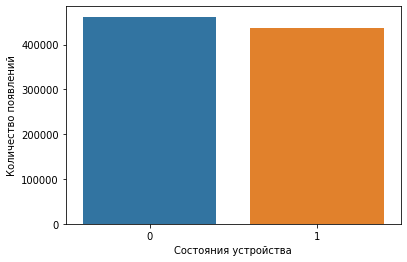

In [5]:
sns.countplot(x=train.target).set(xlabel='Состояния устройства', ylabel='Количество появлений')


Как мы видим, количество состояний *0* и *1* примерно одинаково, с небольшим перевесом в сторону состояния *0*

Теперь проанализируем распределение непрерывных значений признаков относительно целевой переменной

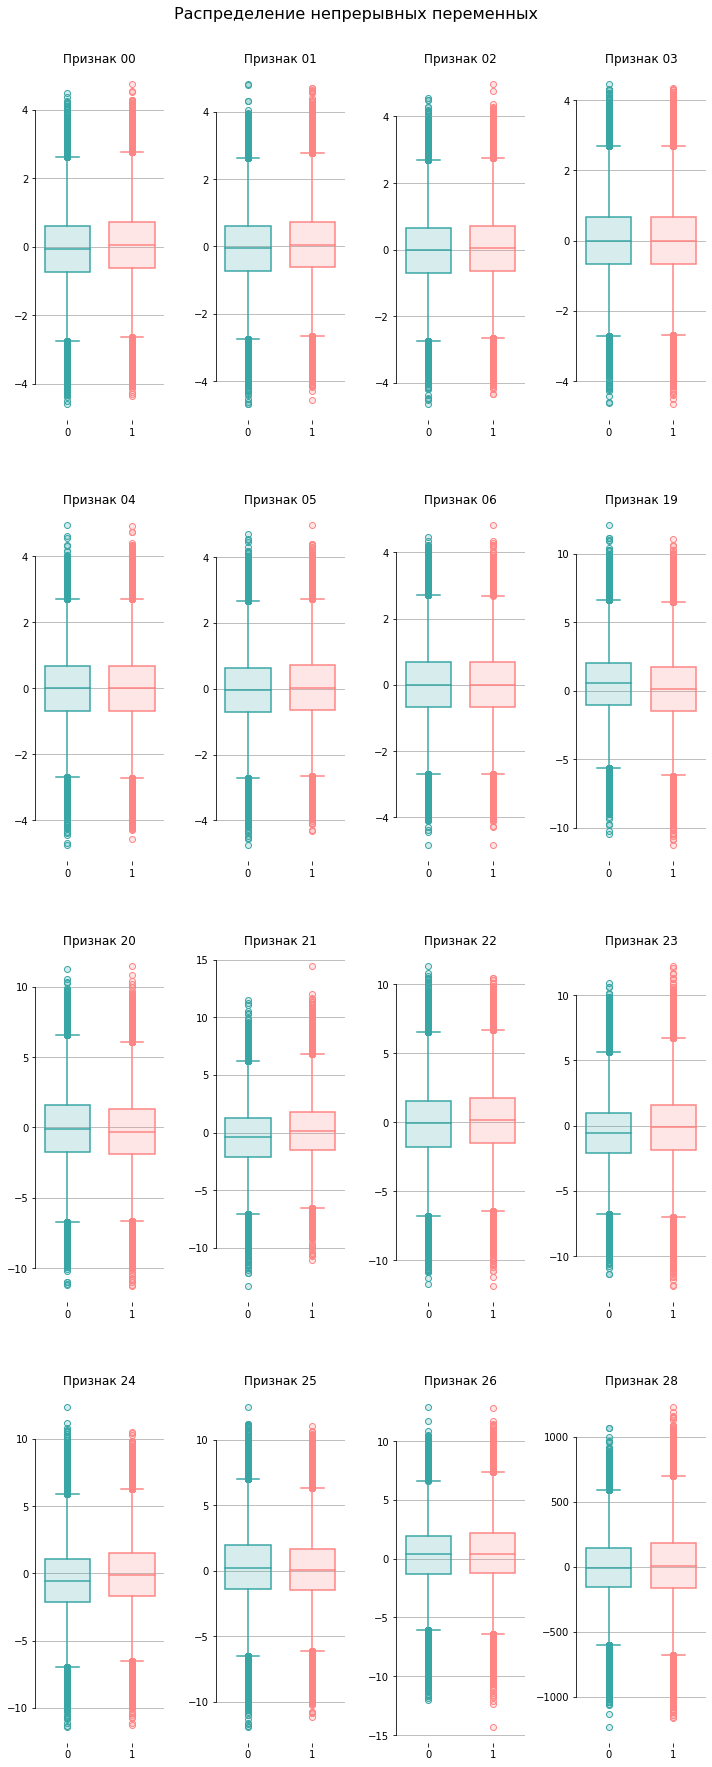

In [6]:
float_cols=train.select_dtypes('float')
float_df=pd.concat([float_cols,train['target']], axis=1)
titles=[f"Признак {i.split('_')[-1]}" for i in float_df.columns]
fig, ax = plt.subplots(4,4, figsize=(10,25))
row=0
col=[0,1,2,3]*4
for i, column in enumerate(float_df.columns[:-1]):
    if (i!=0) & (i%4==0):
        row+=1
    color0='#38A6A5'
    rgb=matplotlib.colors.to_rgba(color0,0.2)
    ax[row,col[i]].boxplot(float_df[float_df.target==0][column], positions=[0], 
                           widths=0.7, patch_artist=True,
                           boxprops=dict(color=color0, facecolor=rgb, linewidth=1.5),
                           capprops=dict(color=color0,linewidth=1.5),
                           whiskerprops=dict(color=color0,linewidth=1.5),
                           flierprops=dict(markerfacecolor=rgb, markeredgecolor=color0),
                           medianprops=dict(color=color0,linewidth=1.5))
    color1='#FF8484'
    rgb=matplotlib.colors.to_rgba(color1,0.2)
    ax[row,col[i]].boxplot(float_df[float_df.target==1][column], positions=[1],
                           widths=0.7, patch_artist=True,
                           boxprops=dict(color=color1, facecolor=rgb, linewidth=1.5),
                           capprops=dict(color=color1, linewidth=1.5),
                           whiskerprops=dict(color=color1, linewidth=1.5),
                           flierprops=dict(markerfacecolor=rgb, markeredgecolor=color1),
                           medianprops=dict(color=color1,linewidth=1.5))
    ax[row,col[i]].set_title(f'\n\n\n{titles[i]}')
    ax[row,col[i]].grid(visible=True, which='major', axis='y')
sns.despine(bottom=True, trim=True)
plt.suptitle('Распределение непрерывных переменных',fontsize=16)
plt.tight_layout()

Также рассмотрим распределение дискретных переменных

In [7]:
temp = dict(layout=go.Layout(font=dict(family="Microsoft Sans Serif", size=12), 
                           height=500, width=1000))
int_df=train.select_dtypes('int')
titles=[f"Признак {i.split('_')[-1]}" for i in int_df.columns[:-1]]

fig = make_subplots(rows=5, cols=3, subplot_titles=titles)
row=0
c=[1,2,3]*5
for i,col in enumerate(int_df.columns[:-1]):
    if i%3==0:
        row+=1
    df=int_df.groupby(col)['target'].value_counts().rename('count').reset_index()
    fig.add_trace(go.Bar(x=df[df.target==0][col], y=df[df.target==0]['count'],width=.2,
                         marker_color=color0,marker_line=dict(color=color0,width=2.5),
                         hovertemplate='Значение: %{x}<br>Количество: %{y}',
                         name='Состояние 0', showlegend=(i==0)),
                  row=row, col=c[i])
    fig.add_trace(go.Bar(x=df[df.target==1][col], y=df[df.target==1]['count'],width=.2,
                         marker_color=color1,marker_line=dict(color=color1,width=2.5), 
                         hovertemplate='Значение: %{x}<br>Количество: %{y}',
                         name='Состояние 1', showlegend=(i==0)),
                  row=row, col=c[i])
    if i%3==0:
        fig.update_yaxes(title='Количество',row=row,col=c[i])
fig.update_layout(template=temp,title="Распределение дискретных переменных",
                  hovermode="x", legend=dict(orientation="h"),
                  barmode='group',height=1500,width=900)
fig.show()

Значительной разницы в распределении признаков относительно состояний нет, есть лишь некоторые смещения индивидуальные для каждого признака. Стоит исследовать корреляцию значения целевой переменной с значениями наших признаков

In [8]:
corr=train.corr().round(2)  
corr=corr.iloc[:-1,-1].sort_values(ascending=False)
titles=[f"Признак {i.split('_')[-1]}" for i in corr.index]
corr.index=titles
pal=sns.color_palette("RdYlBu",32).as_hex()
pal=[j for i,j in enumerate(pal) if i not in (14,15)]
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.8)) for i in pal] 
fig=go.Figure()
fig.add_trace(go.Bar(x=corr.index, y=corr, marker_color=rgb,
                     marker_line=dict(color=pal,width=2),
                     hovertemplate='%{x} Корреляция с целевой переменной = %{y}',
                     showlegend=False, name=''))
fig.update_layout(template=temp, title='Исследование влияния признаков на результат', 
                  yaxis_title='Корреляция', xaxis_tickangle=45, width=800)
fig.show()

Присутствует значительная положительная корреляция таргета с признаками *21,24* и отрицательная корреляция с признаками *19,11*

Рассмотрим теперь взаимосвязь признаков между собой

In [9]:
corr=train.iloc[:,:-1].corr().round(2)  
mask=np.triu(np.ones_like(corr, dtype=bool))
c_mask = np.where(~mask, corr, 100)
c=[]
for i in c_mask.tolist()[1:]:
    c.append([x for x in i if x != 100])
    
cor=c[::-1]
x=corr.index.tolist()[:-1]
y=corr.columns.tolist()[1:][::-1]
fig=ff.create_annotated_heatmap(z=cor, x=x, y=y,
                                hovertemplate='Корреляция между %{x} и %{y}= %{z}',
                                colorscale='blues', reversescale=True, name='')
fig.update_layout(template=temp, title='Взаимозависимость признаков',
                  yaxis=dict(showgrid=False,autorange="reversed"),
                  xaxis=dict(showgrid=False), height=1000,width=1000)
fig.show()

Взаимосвязь между признаками в общем весьма мала, кроме положительной корреляции между признаками *28* и *3,5*, *22* и *30*; и отрицательной корреляции между признаками *23* и *25*

# 3. Конструирование признаков (Feature Engineering)

Среди всех выделяется признак *27* - он представляет собой значение string длины 10. Самый лучший вариант для такого случая - воспользоваться ordinal encoding'ом для каждой позиции буквы в признаке, получив 10 новых признаков.

In [10]:
enc = OrdinalEncoder()
def feature_eng(df):
    df=df.copy()
    for i in range(df.f_27.str.len().max()):
        df[f'f_27_char{i+1}']=enc.fit_transform(df['f_27'].str.get(i).values.reshape(-1,1))
    return df.drop(['f_27'],axis=1)

train_df=feature_eng(df=train)
test_df=feature_eng(df=test)

Оценим распределение букв в *27* признаке

In [11]:
df=train[['f_27']]
for letter in string.ascii_uppercase:
    df[f'{letter}']=df['f_27'].str.count(letter)
df_sum=df.iloc[:,1:].sum(axis=0).rename('sum').reset_index()
pal=sns.color_palette("Spectral_r",44).as_hex()
pal=[j for i,j in enumerate(pal)]
rgb=['rgba'+str(matplotlib.colors.to_rgba(i)) for i in pal] 
fig = go.Figure()
fig.add_trace(go.Bar(x=df_sum['index'], y=df_sum['sum'], marker_color=rgb, 
                     marker_line=dict(color=pal,width=2), name='',
                     hovertemplate='Буква: %{x}, Частота: %{y}',
                     showlegend=False))
fig.update_layout(template=temp,title="Частота появления буквы",
                  yaxis_title="Частота", width=800)
fig.show()

# 4.Градиентный бустинг

Воспользуемся бустингом деревьев решений

In [12]:
scaler = StandardScaler()
y=train_df['target']
X=train_df.drop(['target'], axis=1)
X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
X_test=pd.DataFrame(scaler.transform(test_df))

y_valid, gbm_val_preds, gbm_test_preds, cal_true, cal_pred=[],[],[],[],[]
feature_importance=pd.DataFrame(index=X.columns)
k_fold = KFold(n_splits=3, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
    print(f"\nFold {fold+1}")
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_val, y_val = X.iloc[val_idx,:], y[val_idx]
    
    params = {'boosting_type': 'gbdt',
              'n_estimators': 100,
              'num_leaves': 40,
              'colsample_bytree': 0.9,
              'subsample': 0.8,
              'reg_alpha': 0.1,
              'objective': 'binary',
              'metric': 'auc',
              'random_state': 42}
    
    gbm = LGBMClassifier(**params).fit(X_train, y_train, 
                                       eval_set=[(X_val, y_val)],
                                       verbose = 50,
                                       eval_metric=['auc'])
    
    gbm_prob = gbm.predict_proba(X_val)[:,1]
    y_valid.append(y_val)
    gbm_val_preds.append(gbm_prob)
    gbm_test_preds.append(gbm.predict_proba(X_test)[:,1])
    feature_importance["Feat importance Fold: "+str(fold)]=gbm.feature_importances_
    
    calibrated_gbm = CalibratedClassifierCV(base_estimator=gbm, cv="prefit")
    cal_fit = calibrated_gbm.fit(X_train, y_train)
    cal_probs = calibrated_gbm.predict_proba(X_val)[:, 1]
    prob_true, prob_pred = calibration_curve(y_val, cal_probs, n_bins=10)
    cal_true.append(prob_true)
    cal_pred.append(prob_pred)
    auc_score=roc_auc_score(y_val, gbm_prob)
    print(f"Валидационный AUC = {auc_score}")


Fold 1
[50]	valid_0's auc: 0.915885
[100]	valid_0's auc: 0.934681
Валидационный AUC = 0.9346808840672306

Fold 2
[50]	valid_0's auc: 0.915259
[100]	valid_0's auc: 0.934733
Валидационный AUC = 0.9347333302936016

Fold 3
[50]	valid_0's auc: 0.915318
[100]	valid_0's auc: 0.93496
Валидационный AUC = 0.9349597668136093


0.93 - Вполне неплохой результат, построим соответствующий график

In [13]:
colors=px.colors.qualitative.Prism
def plot_roc(y_val, y_prob):
    fig=go.Figure()
    fig.add_trace(go.Scatter(x=np.linspace(0,1,11), y=np.linspace(0,1,11), 
                             name='Случайный прогноз',mode='lines',
                             line=dict(color="Black", width=1, dash="dot")))
    for i in range(len(y_val)):
        y=y_val[i]
        prob=y_prob[i]
        fpr, tpr, thresh = roc_curve(y, prob)
        roc_auc = auc(fpr,tpr)
        fig.add_trace(go.Scatter(x=fpr, y=tpr, line=dict(color=colors[::-1][i+6], width=3), 
                                 hovertemplate = 'Доля True Positive = %{y:.3f}, Доля False positive= %{x:.3f}',
                                 name=f'Fold {i+1} AUC = {roc_auc:.4f}'))
    fig.update_layout(template=temp, title="Кросс-валидационные ROC кривые", 
                      hovermode="x unified", width=600,height=500,
                      xaxis_title='Доля False positive',
                      yaxis_title='Доля True Positive',
                      legend=dict(orientation='v', y=.07, x=1, xanchor="right",
                                  bordercolor="black", borderwidth=.5))
    fig.show()
    
plot_roc(y_valid, gbm_val_preds)

И напоследок проанализируем значимость признаков для нашей модели

In [14]:
feature_importance['avg']=feature_importance.mean(axis=1)
feature_importance=feature_importance.sort_values(by='avg',ascending=True)

pal=sns.color_palette("YlGnBu", 55).as_hex()
fig=go.Figure()
for i in range(len(feature_importance.index)):
    fig.add_shape(dict(type="line", y0=i, y1=i, x0=0, x1=feature_importance['avg'][i], 
                       line_color=pal[::-1][i],opacity=0.8,line_width=4))
fig.add_trace(go.Scatter(x=feature_importance['avg'], y=feature_importance.index, mode='markers', 
                         marker_color=pal[::-1], marker_size=8,
                         hovertemplate='%{y} Значимость = %{x:.0f}'))
fig.update_layout(template=temp,title='Значимость признаков', 
                  xaxis=dict(title='Средняя значимость',zeroline=False),
                  yaxis_showgrid=False, height=900, width=800)
fig.show()

Самыми важными признаками для осуществления классификации являются признаки *26, 21, 22, 30*